# Bio-swell! Validating the role of stormwater spreading grounds in dense urban environments 


### Outline: 
     Background
        - Benefits of "green infrastructure"
        - Why does this matter?
        - Analysis goals
     Data and analysis 
        - Sentinel-2 geospatial data
        - Location
        - NDMI 
        - Cloud masking
     Results 
     Data Sources



## Background

Stormwater spreading grounds are large-scale green infrastructure projects that help redirect and recapture stormwater runoff from impermeable hardscapes. 

At first glance, these features may appear to have little value in the typical urban environment. They often defined by open areas with little vegetation or defining terrain features, and typically look like a patch of undeveloped of land in an otherwise well-developed urban area. 

### Benefits of "green infrastructure"

So why are these types of projects incorporated so frequently into many large cities? Despite their appearance, these features play a critical role in balancing the interactions between the natural and built environment, including by:  
- Recharging local groundwater resources
- Flattening spikes in peak flow volumes after heavy precipitation
- Reducing pollutant discharge into local water systems 


### Why does this matter?

Sustainable urban development requires looking ahead at the long-term impacts that developed areas have on the natural environment. 

The benefits of green infrastructure projects are becoming increasingly important as cities and urban hubs plan how to mitigate the adverse effects of climate change, particularly on water availability and changing preciptation norms, over the next century.  

### Goals

This analysis will help measure and validate the role of stormwater spreading grounds in the Los Angeles region through measurement of moisture level and  local precipitation data. 


In [1]:
import os
import earthpy as et

from PIL import Image

!pip install utm

import utm

# Import Packages
# %run functions.ipynb

from glob import glob
from datetime import datetime
import nbconvert

import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em

import scipy.stats
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.axes._axes import _log as matplotlib_axes_logger

from itertools import groupby
from osgeo import gdal
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
    
import geopandas as gpd
import rasterio as rio
import xarray as xr
import rioxarray as rxr
from shapely.geometry import mapping
import numpy.ma as ma
from rasterio.plot import plotting_extent
import rasterstats as rs
from shapely.geometry import box

from scipy import stats


%matplotlib inline

# Download data and set working directory
os.chdir(os.path.join(et.io.HOME, 
                      'earth-analytics', 
                      'urban-stormwater-capture'))

#### Below: Pacoima Spreading Grounds in Los Angeles, CA after heavy rainfall


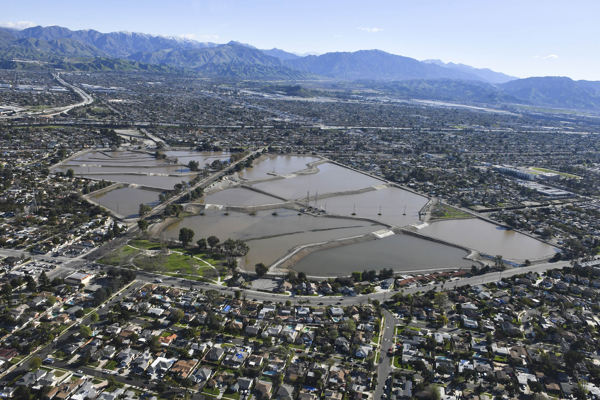

In [2]:
image = Image.open(os.path.join("graphics",
                                "Pacoima-SG1.jpg"))

image.thumbnail((600, 600))
image.save('image_thumbnail.jpg')

image

## Data and Analysis 


### Sentinel-2 geospatial data
This analysis will use Sentinel-2 HLS data, which provides multiple reflective light bands at a 30-meter spatial resolution. 


### Measuring NDMI 
To view the impact of green infrastucture projects on stormwater capture, we will use the Near-Infared (NIR) and Short-Wave Infared (SWIR) Sentinel-2 bands to calculate the Normalized Difference Moisture Index (NDMI) of both project areas and the surrounding region. 

*NDMI = (Band 8 (NIR) – Band 11 (SWIR)) / (Band 8 (NIR) + Band 11 (SWIR))*

NDMI is primarily used to determine vegetation water content. Ideally, these project areas will show greater effectivness in capturing and retaining stormwater runoff longer efficacy of saturated soils. 

#### How exactly does NDMI correlate with moisture levels? 

This table below shows how the NDMI measurement relates to different levels of soil saturation, vegetation, and/or water stress for a given area:

| NDMI | Interpretation |
|   :---   |   :---  |
|-1 – -0.8 |Bare soil |
|-0.8 – -0.6 | Almost absent canopy cover |
|-0.6 – -0.4 | Very low canopy cover |
|-0.4 – -0.2 |Low canopy cover, dry or very low canopy cover, wet |
|-0.2 – 0 |Mid-low canopy cover, high water stress or low canopy cover, low water stress |
|0 – 0.2 |Average canopy cover, high water stress or mid-low canopy cover, low water stress |
|0.2 – 0.4 |Mid-high canopy cover, high water stress or average canopy cover, low water stress |
|0.4 – 0.6 |High canopy cover, no water stress |
|0.6 – 0.8 |Very high canopy cover, no water stress |
|0.8 – 1 |Total canopy cover, no water stress/waterlogging |

### Where is our project area? 

This analysis focuses primarly on the Eaton Stormwater Spreading Grounds. This stormwater spreading ground site is located in Pasadena - part of the Los Angeles metropolitan area. 

In [3]:
import folium 
la_map = folium.Map(location=[34.0522, -118.2437])
la_map

In [4]:
# set up paths to data

# LA spreading grounds shapefiles
shape_spread_path = os.path.join("data",
                                 "la-spreading-grounds",
                                 "Spreading_Grounds_Feature_Layer.shp")                                 
shape_spread_data = gpd.read_file(shape_spread_path)

#LA catchment areas shapefiles
shape_catchment_path = os.path.join("data",
                                    "la-catchment-areas",
                                    "Los_Angeles_County_Catchment_Areas.shp")                                 
shape_catchment_data = gpd.read_file(shape_catchment_path)

#LA area region crop 
la_crop_path = os.path.join("data",
                       "Sentinel-2-Shapefile-Index",
                       "sentinel_2_index_shapefile.shp")

la_crop_data = gpd.read_file(la_crop_path).loc[
                                            gpd.read_file(la_crop_path)["Name"]=="11SLT"]

#City boundaries shapefiles

city_boundaries_path = os.path.join("data",
                                    "la-city-boundaries",
                                    "City_Boundaries.shp")   

city_boundaries_data = gpd.read_file(city_boundaries_path)

city_boundaries_data.rename(columns = {'CITY_NAME':'NAME'}, inplace = True)


#LA streams and rivers shapefiles 
la_streams_rivers_path = os.path.join("data",
                                     "la-streams-rivers",
                                     "geo_export_339f28ec-e123-431b-a506-4d994dfd8153.shp")
la_streams_rivers_data = gpd.read_file(la_streams_rivers_path)


#Sentinel-2 data paths

sent_2019_2021_path = os.path.join("data", 
                                  "sent-2019-2021")
sent_landsat_hls_path = os.path.join("data",
                                    "sent-landsat-hls")

#Select path that will be used primarily for analysis
sent_path = os.path.join(sent_2019_2021_path)


# precipitation data paths

ges_precip_path = os.path.join("data",
                                "ges-precip-data")

#Paths to access NIR (Band 8) and SWIR (Band 11) 
band_8_paths = glob(os.path.join(sent_path,"*B08*.tif")) 
band_11_paths = glob(os.path.join(sent_path,"*B11*.tif"))
qa_layer_paths = glob(os.path.join(sent_path,"*Fmask*.tif"))

landsat_band_5 = glob(os.path.join(sent_landsat_hls_path,"*B05*.tif"))
landsat_band_6 = glob(os.path.join(sent_landsat_hls_path,"*B06*.tif"))
landsat_qa_layer = glob(os.path.join(sent_landsat_hls_path,"*Fmask*.tif"))

      

ndmi_band_paths = band_8_paths + band_11_paths
all_band_paths = band_8_paths + band_11_paths + qa_layer_paths

sent_landsat_band_paths = landsat_band_5 + landsat_band_6 + landsat_qa_layer

In [5]:

### Follow Sentinel-2 HLS documentation to create masking value references ## 

# Git: https://git.earthdata.nasa.gov/projects/LPDUR/repos/hls-tutorial/browse/HLS_Tutorial.ipynb#processhls

def cloud_mask (fmask):
    
    """
    Create bit dictionary and map Sentinel-2 HLS quality assurance (QA) layers from bits
    

    """

    # bitword dictionaries 

    bitword_order = (1, 1, 1, 1, 1, 1, 2)  # set the number of bits per bitword
    num_bitwords = len(bitword_order)      # Define the number of bitwords based on your input above
    total_bits = sum(bitword_order)        # Should be 8, 16, or 32 depending on datatype

    # Loop to create cloud mask lookup from Git documentation 

    qVals = list(np.unique(fmask))  # Create a list of unique values that need to be converted to binary and decoded

    all_bits = list()
    summary_bits=list()

    goodQuality = []
    for v in qVals:
        all_bits = []
        bits = total_bits
        i = 0

        # Convert to binary based on the values and # of bits defined above:
        bit_val = format(v, 'b').zfill(bits)
#         print('\n' + str(v) + ' = ' + str(bit_val))
        all_bits.append(str(v) + ' = ' + str(bit_val))

        # Go through & split out the values for each bit word based on input above:
        for b in bitword_order:
            prev_bit = bits
            bits = bits - b
            i = i + 1
            if i == 1:
                bitword = bit_val[bits:]
#                 print(' Bit Word ' + str(i) + ': ' + str(bitword))
                all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword)) 
            elif i == num_bitwords:
                bitword = bit_val[:prev_bit]
#                 print(' Bit Word ' + str(i) + ': ' + str(bitword))
                all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword))
            else:
                bitword = bit_val[bits:prev_bit]
#                 print(' Bit Word ' + str(i) + ': ' + str(bitword))
                all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword))

#       1 = Cirrus, 2 = Cloud, 3 = Cloud adjacent, 4 = cloud shadow, 5 = snow/ice, 6 = water, 7 = aerosol
        if int(all_bits[1].split(': ')[-1]) < 1 and \
            int(all_bits[2].split(': ')[-1]) < 1 and \
            int(all_bits[3].split(': ')[-1]) < 1 and \
            int(all_bits[4].split(': ')[-1]) < 2 and \
            int(all_bits[5].split(': ')[-1]) < 1 and \
            int(all_bits[6].split(': ')[-1]) < 2 and \
                int(all_bits[7].split(': ')[-1]) < 12:
        
            goodQuality.append(v)
            
    # test values that do not need to be masked 
    return goodQuality

In [6]:
def open_clean_bands(band_path,
                     crop_bound,
                     valid_range,
                    pixel_qa_path):
    
    """
    Open, clean, and crop a file into an xarray DataArray.

    Parameters
    -----------
    band_path:string
        A path to the array to be opened
    crop_bound:geopandas GeoDataFrame
        A geopandas dataframe to be used to crop the raster data using rioxarray clip().
    valid_range:tuple (optional)
         A tuple of min and max range of values for the data. Default = None

    Returns
    -----------

    band : xarray DataArray
        End result for a cropped xarray dataarray
    """

#     crop_bound_box = [box(*crop_bound.total_bounds)]

    try:
        band = rxr.open_rasterio(band_path,
                                 masked=True).rio.clip(
                                                        crop_bound.geometry,
                                                        crs=crop_bound.crs,
                                                        all_touched=True,
                                                        from_disk=True).squeeze()
    
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

        # open and mask cloud layer
        cl_mask = (rxr.open_rasterio(pixel_qa_path, masked=True)
                        .rio.clip(
                            crop_bound.geometry,
                            from_disk=True).squeeze())

        # apply cloud mask
        band = band.where(cl_mask.isin(goodQuality)).squeeze()
        
    except:
        raise ValueError(
            "Oops - I couldn't clip your data. This may be due to a crs error.")

    return band

In [7]:


# test bands for a single site 

#band 8
test_tif_NIR = os.path.join("data",
                          "sent-landsat-hls",
                        "HLS.L30.T11SLT.2019006T182811.v2.0.B05.tif")

#band 11
test_tif_SWIR = os.path.join("data", 
                           "sent-landsat-hls",
                        "HLS.L30.T11SLT.2019006T182811.v2.0.B06.tif")

#create rasters for bands 8 and 11
test_rxr_NIR = rxr.open_rasterio(test_tif_NIR,masked=True).squeeze()

test_rxr_SWIR = rxr.open_rasterio(test_tif_SWIR,masked=True).squeeze()

#### Project area
- Eaton Spreading Grounds

In [8]:
#reproject shape files to crs 
la_reproj_crop = la_crop_data.to_crs(test_rxr_SWIR.rio.crs)

#spreading ground reprojections for Eaton Spreading Grounds

spreading_shape_reproj = shape_spread_data.to_crs(test_rxr_SWIR.rio.crs)

eaton_shape = spreading_shape_reproj.loc[
                                        spreading_shape_reproj['NAME'] == "EATON S.G."]

# rio_hondo_shape = spreading_shape_reproj.loc[
#                                         spreading_shape_reproj['NAME'] == "RIO HONDO COASTAL BASIN S.G."]

#Reprojections for other potential shapefiles 

city_boundaries_reproj = city_boundaries_data.to_crs(test_rxr_SWIR.rio.crs)

pasadena_shape = city_boundaries_reproj.loc[
                                        city_boundaries_reproj['NAME'] == "Pasadena"]

# montebello_shape = city_boundaries_reproj.loc[
#                                         city_boundaries_reproj['NAME'] == "Montebello"]

#create plot extents for site (LA) and project area (Eaton SG)

la_plot_extent = plotting_extent(test_rxr_SWIR, 
                                   test_rxr_SWIR.rio.transform())

eaton_shape


,OBJECTID,ID,NAME,OWNER_OPER,BASIN_TYPE,NO__OF_BAS,SEASON_FIR,GROSS_AREA,WETTED_ARE,CHANNEL,INTAKES,STORAGE,PERCOLATIO,CONTROLLED,UNCONTROLL,EQNUM,MXCREATION,SHAPEAREA,SHAPELEN,geometry
34,35,W,EATON S.G.,LOS ANGELES COUNTY - DPW,DEEP & SHALLOW,14,1947-48,28 ACRES,25.0 ACRES,6600 CFS,200 CFS,525 AF,14 CFS,EATON WASH DAM,IMPORTED WATER,None,1,5.282895e+06,25754.052128,"MULTIPOLYGON (((399200.586 3781846.894, 399202..."


#### Surrounding region to project area 

- City of Pasadena, CA

In [9]:
pasadena_shape

,OBJECTID,CITY,CITY_ID,CITY_TYPE,NAME,CITY_LABEL,COLOR_CODE,ABBR,CITY_NO,DESCRIPTN,URL,PHONE,OF_AREA_SM,FEAT_TYPE,COMMENT,COLOR_EGIS,POPULATION,ShapeSTAre,ShapeSTLen,geometry
115,47507,None,None,City,Pasadena,Pasadena,2,None,61,PAS,www.ci.pasadena.ca.us,6267444000,23.14,Land,None,"Pink - RGB 255,190,232",None,6.441804e+08,283063.986525,"POLYGON ((390707.062 3789106.810, 390705.099 3..."


In [10]:
# Create path for the pixel_qa_layer for subdirectory scene
scene_pixel_qa_path = os.path.join(sent_landsat_hls_path,
                                  "HLS.L30.T11SLT.2019006T182811.v2.0.Fmask.tif")

sent_qa = rxr.open_rasterio(scene_pixel_qa_path).squeeze()

#define valid values to be exluded from mask
goodQuality = cloud_mask(fmask = sent_qa)

### Cloud Masking

Cloud masks necessary to remove data values impacted by clouds or other atmospheric interference from satellite imagery. Sentinel-2 HLS provides an "Fmask" quality assurance (QA) band along with each data file, along with documentation on how to properly utilize different masking features.  

Git: https://git.earthdata.nasa.gov/projects/LPDUR/repos/hls-tutorial/browse/HLS_Tutorial.ipynb#processhls

#### An example of masking "bad" data pixels

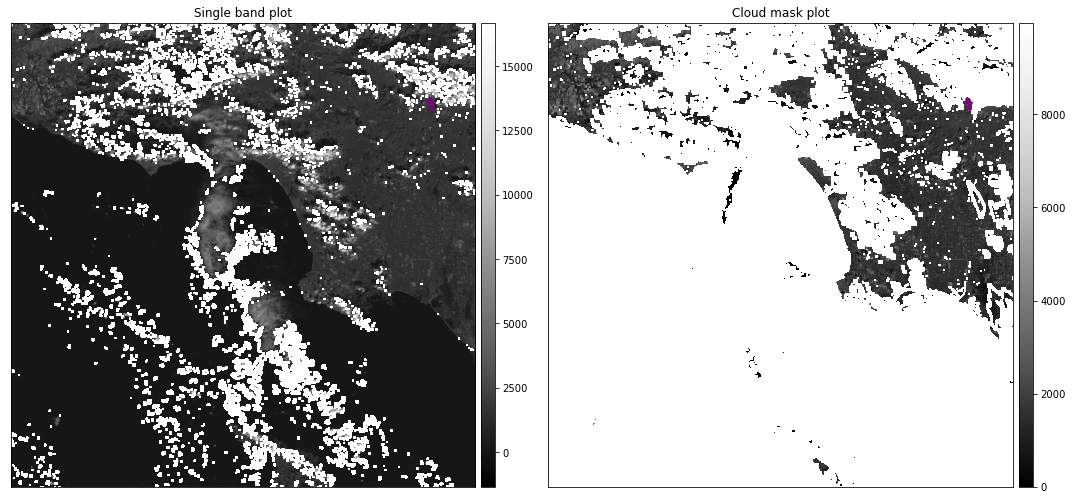

In [11]:

# #test ndmi
test_ndmi_xr = (test_rxr_NIR-test_rxr_SWIR) / (test_rxr_NIR+test_rxr_SWIR)

masked_test_NIR = open_clean_bands(test_tif_NIR, 
                                 crop_bound=la_reproj_crop,
                                 valid_range=(0,10000),
                                 pixel_qa_path=scene_pixel_qa_path)

# test single band raster plot and ndmi plots  
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ep.plot_bands(test_rxr_NIR,
              ax=ax1,
              extent=la_plot_extent,
              cbar="terrain_r",
             title = "Single band plot")

eaton_shape.plot(ax=ax1,
                       color='none',
                       linewidth = 3,
                       edgecolor = 'purple')

ep.plot_bands(masked_test_NIR,
              ax=ax2,
              extent=la_plot_extent,
              cbar="terrain_r",
             title = "Cloud mask plot")

eaton_shape.plot(ax=ax2,
                color='none',
                linewidth = 3,
                edgecolor = 'purple')


plt.tight_layout()
plt.show()

## Results 

First, we create a loop to provide list of the Sentinel-2 NIR and SWIR bands, indexed by date. 

In [12]:
# Create loop to process a sample Sentinel-2 view 
band_list = []

# for tifs in all_band_paths:
for tifs in sent_landsat_band_paths:


    filename = os.path.normpath(tifs).split(os.sep)[-1]
    name_components = filename.split(".")
    site = name_components[2]
    band = name_components[6]
    old_date = name_components[3][0:7]

    datetimeobject = datetime.strptime(old_date,'%Y%j')
    date = datetimeobject.strftime('%m-%d-%Y')
    
    output = [date, band, tifs]
        
    band_list.append(output)
    
band_df = pd.DataFrame(band_list,
                   columns = ["date","band","array"])

band_df['date'] = pd.to_datetime(band_df.date)

indexed_df = band_df.set_index("date").sort_values(by="date")

print(indexed_df.duplicated().sum())
indexed_df

0


,band,array
date,,
2019-01-06,B05,data\sent-landsat-hls\HLS.L30.T11SLT.2019006T1...
2019-01-06,B06,data\sent-landsat-hls\HLS.L30.T11SLT.2019006T1...
2019-01-06,Fmask,data\sent-landsat-hls\HLS.L30.T11SLT.2019006T1...
2019-01-22,B05,data\sent-landsat-hls\HLS.L30.T11SLT.2019022T1...
2019-01-22,B06,data\sent-landsat-hls\HLS.L30.T11SLT.2019022T1...
...,...,...
2022-04-04,B06,data\sent-landsat-hls\HLS.L30.T11SLT.2022094T1...
2022-04-04,B05,data\sent-landsat-hls\HLS.L30.T11SLT.2022094T1...
2022-04-20,B05,data\sent-landsat-hls\HLS.L30.T11SLT.2022110T1...


Then, we pivot the table to group the selected bands by the indexed date. 

In [13]:
band_df.pivot_table(index = "date", columns = "band", values = "array", aggfunc='first')

band,B05,B06,Fmask
date,,,
2019-01-06,data\sent-landsat-hls\HLS.L30.T11SLT.2019006T1...,data\sent-landsat-hls\HLS.L30.T11SLT.2019006T1...,data\sent-landsat-hls\HLS.L30.T11SLT.2019006T1...
2019-01-22,data\sent-landsat-hls\HLS.L30.T11SLT.2019022T1...,data\sent-landsat-hls\HLS.L30.T11SLT.2019022T1...,data\sent-landsat-hls\HLS.L30.T11SLT.2019022T1...
2019-02-07,data\sent-landsat-hls\HLS.L30.T11SLT.2019038T1...,data\sent-landsat-hls\HLS.L30.T11SLT.2019038T1...,data\sent-landsat-hls\HLS.L30.T11SLT.2019038T1...
2019-02-23,data\sent-landsat-hls\HLS.L30.T11SLT.2019054T1...,data\sent-landsat-hls\HLS.L30.T11SLT.2019054T1...,data\sent-landsat-hls\HLS.L30.T11SLT.2019054T1...
2019-03-11,data\sent-landsat-hls\HLS.L30.T11SLT.2019070T1...,data\sent-landsat-hls\HLS.L30.T11SLT.2019070T1...,data\sent-landsat-hls\HLS.L30.T11SLT.2019070T1...
...,...,...,...
2022-02-15,data\sent-landsat-hls\HLS.L30.T11SLT.2022046T1...,data\sent-landsat-hls\HLS.L30.T11SLT.2022046T1...,data\sent-landsat-hls\HLS.L30.T11SLT.2022046T1...
2022-03-03,data\sent-landsat-hls\HLS.L30.T11SLT.2022062T1...,data\sent-landsat-hls\HLS.L30.T11SLT.2022062T1...,data\sent-landsat-hls\HLS.L30.T11SLT.2022062T1...
2022-03-19,data\sent-landsat-hls\HLS.L30.T11SLT.2022078T1...,data\sent-landsat-hls\HLS.L30.T11SLT.2022078T1...,data\sent-landsat-hls\HLS.L30.T11SLT.2022078T1...


In [17]:
#Calculate NDMI through normalized difference of band 8 and 11

# shape_list = [rio_hondo_shape, montebello_shape]
shape_list = [eaton_shape, pasadena_shape]


band_pivot = band_df.pivot_table(index = "date", columns = "band", values = "array", aggfunc='first')


mean_list = []
ndmi_arrays = []
for i, row in band_pivot.iterrows():
    #define bands and perform normalized diff for ndmi
    band_NIR_path = row["B05"]    
    band_SWIR_path = row["B06"]
    mask_path = row["Fmask"]
    
    #loop for both sites
    for shape in shape_list: 

        area_name = shape["NAME"].item()

        #create fmask layer from qa layer path
        band_qa_layer = rxr.open_rasterio(mask_path).squeeze()
        goodQuality = cloud_mask(fmask = band_qa_layer)
        
        # mask NIR and SWIR bands
        masked_band_NIR = open_clean_bands(band_NIR_path,
                                         crop_bound=shape, 
                                         valid_range=(0,10000),
                                         pixel_qa_path=mask_path)

        masked_band_SWIR = open_clean_bands(band_SWIR_path,
                                          crop_bound=shape, 
                                          valid_range=(0,10000),
                                          pixel_qa_path=mask_path)
        
        #calculate normalized difference for ndmi
        ndmi = (masked_band_NIR-masked_band_SWIR) / (masked_band_NIR+masked_band_SWIR)
        
    
        #count number of unmasked pixels to validate data from scene
        clean_pixels = ndmi.count().item()
        total_pixels = ndmi.size
        
        mean_ndmi = ndmi.mean().item()
        
    #Create outputs for mean ndmi list (and ndmi arrays just in case) 
        output_1 = [i, mean_ndmi,area_name, clean_pixels]
        mean_list.append(output_1)

        output_2 = [i,ndmi, masked_band_NIR, masked_band_SWIR, area_name,clean_pixels]
        ndmi_arrays.append(output_2)

        
#Create dataframes for mean NDMI and NDMI arrays
mean_df = pd.DataFrame(mean_list,
                           columns = ["date","mean","area","clean_pixels"])

mean_df["total_pixels"] = max(mean_df["clean_pixels"])

mean_df

,date,mean,area,clean_pixels,total_pixels
0,2019-01-06,-0.024568,EATON S.G.,484,66480
1,2019-01-06,0.157881,Pasadena,48287,66480
2,2019-01-22,0.050962,EATON S.G.,528,66480
3,2019-01-22,0.117113,Pasadena,66433,66480
4,2019-02-07,0.089848,EATON S.G.,501,66480
...,...,...,...,...,...
143,2022-03-19,0.135771,Pasadena,66456,66480
144,2022-04-04,-0.002614,EATON S.G.,501,66480
145,2022-04-04,0.158394,Pasadena,49249,66480
146,2022-04-20,NaN,EATON S.G.,0,66480


In [18]:
#set total pixel counts for both areas based off thier individual maxes

max_eaton_pixel = max(mean_df.loc[mean_df['area'] == "EATON S.G."]["clean_pixels"])
max_pasadena_pixel = max(mean_df.loc[mean_df['area'] == "Pasadena"]["clean_pixels"])

mean_df['total_pixels'] = np.where((mean_df.area =="EATON S.G."),max_eaton_pixel,max_pasadena_pixel)


# max_rio_hondo_pixel = max(mean_df.loc[mean_df['area'] == "RIO HONDO COASTAL BASIN S.G."]["clean_pixels"])
# max_montebello_pixel = max(mean_df.loc[mean_df['area'] == "Montebello"]["clean_pixels"])

# mean_df['total_pixels'] = np.where((mean_df.area =="RIO HONDO COASTAL S.G."),max_rio_hondo_pixel,max_montebello_pixel)

# calculate proportion of good pixels 
mean_df["clean_proportion"] = mean_df["clean_pixels"] / mean_df["total_pixels"]


mean_ndmi_df = mean_df.set_index("date")

ndmi_df = pd.DataFrame(ndmi_arrays,
                           columns = ["date","ndmi","NIR_band","SWIR_band","area","clean_pixels"])

# add proportion for ndmi dataframe as well
ndmi_df['clean_proportion'] = mean_df["clean_proportion"]

# call mean NDMI dataframe                       
mean_ndmi_df.tail()

,mean,area,clean_pixels,total_pixels,clean_proportion
date,,,,,
2022-03-19,0.135771,Pasadena,66456,66480,0.999639
2022-04-04,-0.002614,EATON S.G.,501,538,0.931227
2022-04-04,0.158394,Pasadena,49249,66480,0.740809
2022-04-20,NaN,EATON S.G.,0,538,0.000000
2022-04-20,0.217857,Pasadena,2009,66480,0.030220


In [19]:
# drop data results where they were heavily impacted by cloud cover 

mean_ndmi_df["clean_mean"] = mean_ndmi_df["mean"].where(mean_ndmi_df["clean_proportion"] >= 0.35, axis = None)

# reset index

pasadena_ndmi_df = ndmi_df.loc[ndmi_df['area'] == "Pasadena"].reset_index()
eaton_ndmi_df = ndmi_df.loc[ndmi_df['area'] == "EATON S.G."].reset_index()

# montebello_ndmi_df = ndmi_df.loc[ndmi_df['area'] == "Montebello"].reset_index()
# rio_hondo_ndmi_df = ndmi_df.loc[ndmi_df['area'] == "RIO HONDO COASTAL BASIN S.G."].reset_index()



#### Viewing the Band 8 and Band 11 Arrays for both Project and Surrounding Areas 

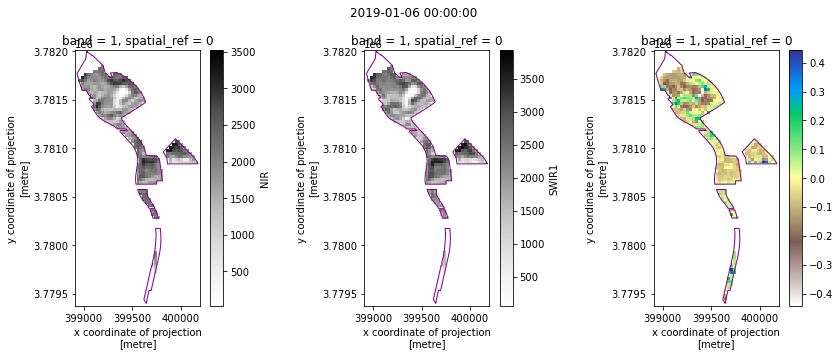

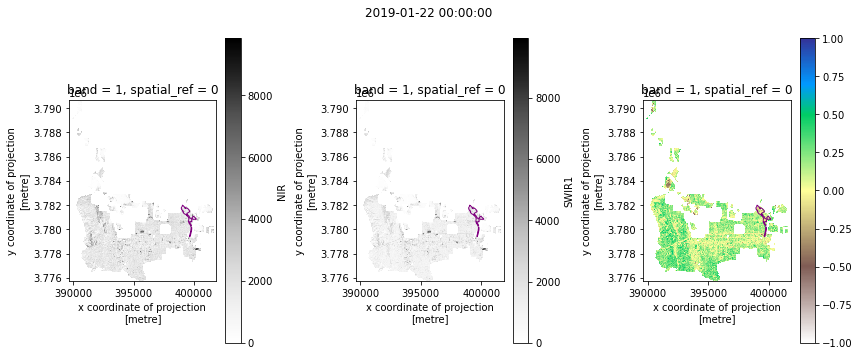

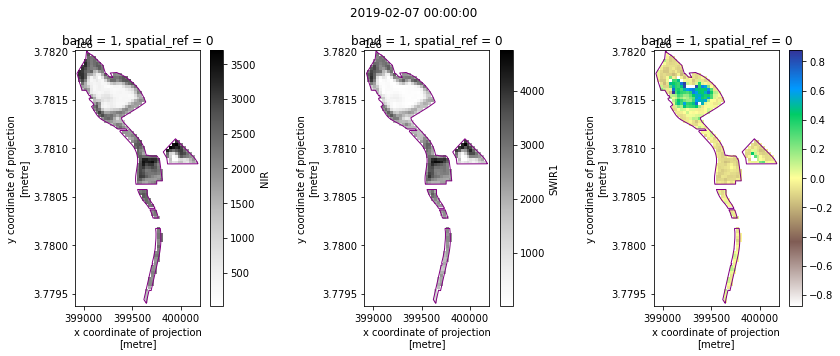

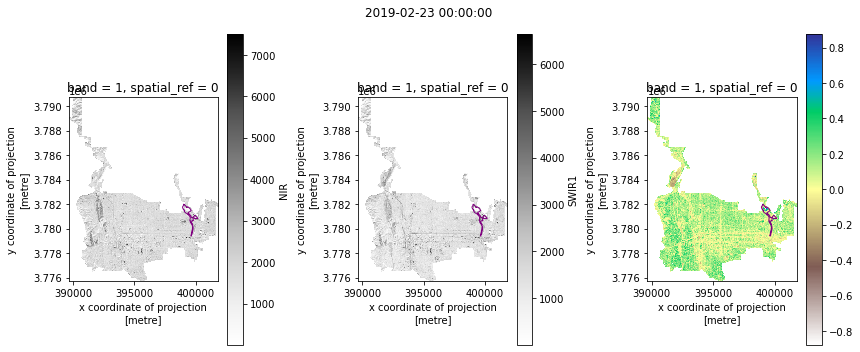

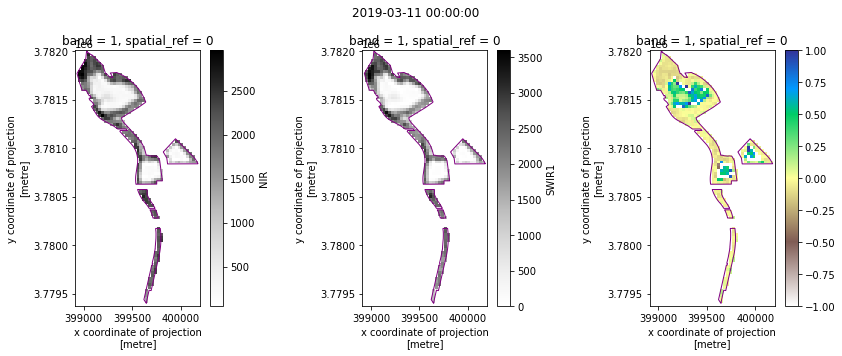

In [20]:
# testing that Bands 0 (8) and 1 (11) are valid
last_five = [61,62,63,64]
first_five = [0,1,2,3,4]

for num in first_five: 

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 5))

    ndmi_df['NIR_band'][num].plot.imshow(ax=ax1, 
                                        cmap = "Greys")
    eaton_shape.plot(ax=ax1,
                     color='none',
                     linewidth = 1,
                     edgecolor = 'purple',
                     vmin=-1,
                     vmax=-1)

    ndmi_df['SWIR_band'][num].plot.imshow(ax=ax2, 
                                        cmap = "Greys")
    eaton_shape.plot(ax=ax2,
                     color='none',
                     linewidth = 1,
                     edgecolor = 'purple',
                     vmin=-1,
                     vmax=-1)
    
    ndmi_df['ndmi'][num].plot.imshow(ax=ax3, 
                                        cmap = "terrain_r")
    eaton_shape.plot(ax=ax3,
                     color='none',
                     linewidth = 1,
                     edgecolor = 'purple',
                     vmin=-1,
                     vmax=-1)
    
    plt.suptitle(pasadena_ndmi_df['date'][num])
    plt.tight_layout()


#### Visual comparison of mean NDMI for the Project Area vs. Surrounding Area for select dates

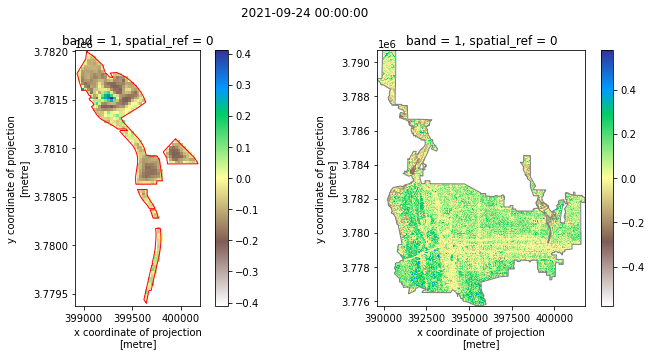

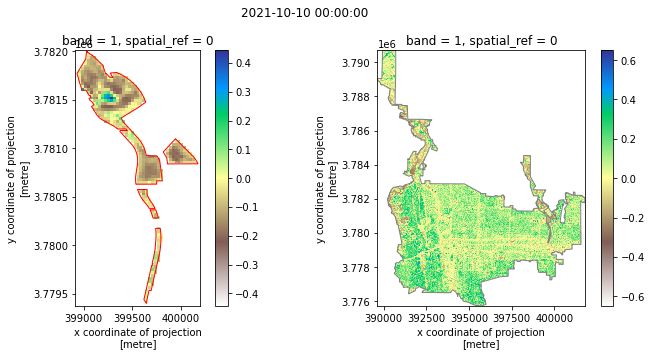

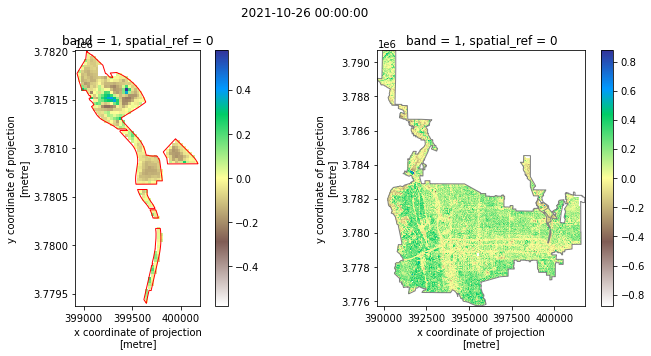

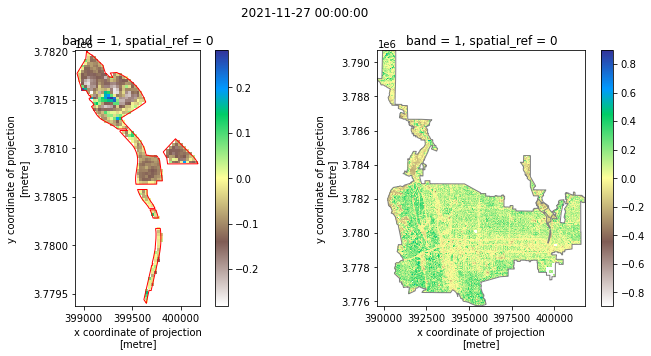

In [21]:
for num in last_five:

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))

    eaton_ndmi_df['ndmi'][num].plot.imshow(ax=ax1, 
                                            cmap = "terrain_r")
    eaton_shape.plot(ax=ax1,
                     color='none',
                     linewidth = 1,
                     edgecolor = 'red',
                     vmin=-1,
                     vmax=-1)

    pasadena_ndmi_df['ndmi'][num].plot.imshow(ax=ax2, 
                                            cmap = "terrain_r")
    pasadena_shape.plot(ax=ax2,
                    color='none',
                    linewidth = 1,
                    edgecolor = 'grey',
                    vmin=-1,
                    vmax=-1)

    eaton_shape.plot(ax=ax2,
                     color='none',
                     linewidth = 1,
                     edgecolor = 'grey',
                     vmin=-1,
                     vmax=-1)

    plt.suptitle(pasadena_ndmi_df['date'][num])
    plt.tight_layout()
    plt.show()

### Findings

The comparison of mean NDMI between the Eaton Stormwater Spreading Grounds and surrounding Pasadena area uncovers a few data insights: 

1. The spreading ground area has higher variance in in mean NDMI, validating the role of capturing stormwater and maintainng saturated soils for longer 

2. Urban areas may still have a higher average NDMI due to the prevalance of urban landscaping such as trees, landscaped areas, and other dedicated greenspace such as parks


In [22]:
nc4_test = os.path.join(ges_precip_path,
                        "3B-DAY-L.MS.MRG.3IMERG.20220513-S000000-E235959.V06.nc4.SUB.nc4")

all_precip_paths = glob(os.path.join(ges_precip_path,
                                    "*"))

appended_precip_list = []

# precip_name_components
for file in all_precip_paths:

    precip_filename = os.path.normpath(file).split(os.sep)[-1]
    precip_name_components = precip_filename.split(".")
    
    precip_date = precip_name_components[4][0:8]

    precip_datetime = datetime.strptime(precip_date, '%Y%m%d').strftime('%m/%d/%Y')
    
    metadata = xr.open_dataset(file)
    metadata_df = metadata.to_dataframe()
    metadata_df.reset_index(inplace=True)

        
    appended_precip_list.append(metadata_df)
    
precip_df = pd.concat(appended_precip_list)


precip_df

C:\Users\JensenWidtfeldt\miniconda3\envs\earth-analytics-python\lib\site-packages\xarray\backends\plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(python-dateutil 2.8.0 (c:\users\jensenwidtfeldt\miniconda3\envs\earth-analytics-python\lib\site-packages), Requirement.parse('python-dateutil>=2.8.1'), {'pandas'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


,time,bnds,lon,lat,time_bnds,precipitationCal,precipitationCal_cnt_cond,HQprecipitation,HQprecipitation_cnt_cond
0,2019-01-01,0,-118.849991,33.350002,2019-01-01 00:00:00,0.0,0,0.0,0
1,2019-01-01,0,-118.849991,33.450001,2019-01-01 00:00:00,0.0,0,0.0,0
2,2019-01-01,0,-118.849991,33.549999,2019-01-01 00:00:00,0.0,0,0.0,0
3,2019-01-01,0,-118.849991,33.649998,2019-01-01 00:00:00,0.0,0,0.0,0
4,2019-01-01,0,-118.849991,33.750004,2019-01-01 00:00:00,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...
307,2022-06-01,1,-117.649994,34.049999,2022-06-01 23:59:59,0.0,0,0.0,0
308,2022-06-01,1,-117.649994,34.149998,2022-06-01 23:59:59,0.0,0,0.0,0
309,2022-06-01,1,-117.649994,34.250004,2022-06-01 23:59:59,0.0,0,0.0,0
310,2022-06-01,1,-117.649994,34.350002,2022-06-01 23:59:59,0.0,0,0.0,0


In [23]:


# determine aoi bounds on utm scale     
aoi_lat_y = [float(eaton_shape.total_bounds[1]), float(eaton_shape.total_bounds[3])]
aoi_lon_x = [float(eaton_shape.total_bounds[0]), float(eaton_shape.total_bounds[2])]

aoi_centroid = [sum(aoi_lon_x)/2, sum(aoi_lat_y)/2]
aoi_centroid_utm = utm.to_latlon(aoi_centroid[0],aoi_centroid[1], 11, 'N')

#select precip coords near aoi centroid
precip_df_aoi = precip_df[(precip_df['lat'].between(34.14,34.15)) &
                                   (precip_df['lon'].between(-118.1,-118)) & 
                                    (precip_df['bnds'] == (0))]
                                                                 
                                    
precip_df_aoi.set_index("time",inplace=True)

# precip_df_aoi = precip_df_aoi.join(mean_ndmi_df["mean"])

# precip_df_aoi["mean"].plot.hist()

#### Time-series comparison of mean NDMI values for both areas 

Text(0.5, 1.0, 'Comparison of NDMI \n Eaton Spreading Grounds vs Surrounding Area (Pasadena) ')

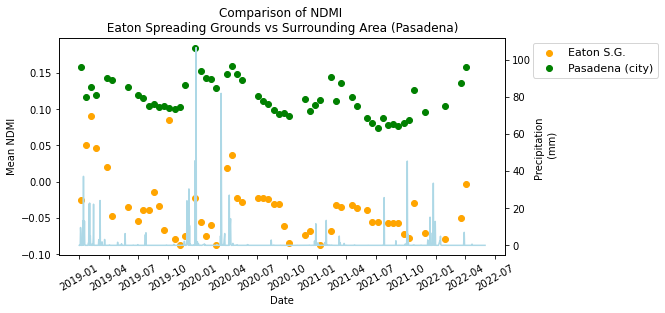

In [30]:
fig, ax1 = plt.subplots(figsize=(8,4)) #consider a qqplot or probplot?

ax1.scatter(mean_ndmi_df[mean_ndmi_df["area"] == "EATON S.G."].index, 
        mean_ndmi_df[mean_ndmi_df["area"] == "EATON S.G."]["clean_mean"],
        label="Eaton S.G.",
        color="orange")

ax1.scatter(mean_ndmi_df[mean_ndmi_df["area"] == "Pasadena"].index, 
        mean_ndmi_df[mean_ndmi_df["area"] == "Pasadena"]["clean_mean"],
        label="Pasadena (city)",
        color="green")

# add precip data on same graph but opposite x axis
ax2 = ax1.twinx()
ax2.plot(precip_df_aoi.index, 
        precip_df_aoi["precipitationCal"],
        label="Precipitation (mm)",
        color="lightblue")

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
          prop={'size': 11})

ax1.set(xlabel = "Date",
       ylabel = "Mean NDMI")

ax2.set_ylabel('Precipitation \n (mm)')


plt.setp(ax1.get_xticklabels(), rotation = 30)

ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top') 

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))


plt.title("Comparison of NDMI \n Eaton Spreading Grounds vs Surrounding Area (Pasadena) ")

AttributeError: 'numpy.ndarray' object has no attribute 'boxplot'

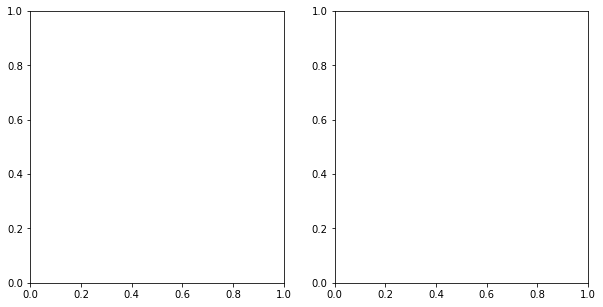

In [25]:
for num in first_five:

    fig, ax = plt.subplots(1,2, figsize=(10, 5))

    ax.boxplot(eaton_ndmi_df['ndmi'][num])


ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
          prop={'size': 11})

ax.set(xlabel = "Date",
       ylabel = "Mean NDMI")


plt.setp(ax.get_xticklabels(), rotation = 30)


ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))


plt.title("Comparison of NDMI \n Eaton Spreading Grounds vs Surrounding Area (Pasadena) ")

In [ ]:
!jupyter nbconvert --to html  --no-input ea-capstone-workbook-2022.ipynb

##  Data Sources 

- Sentinel-2 HLS Data: https://search.earthdata.nasa.gov/search
- GES Precipitation Data: https://search.earthdata.nasa.gov/search
- City of Los Angeles Open Data: https://data.lacity.org/
- City of Los Angeles GeoHub: https://geohub.lacity.org/ 